<img src="https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png" alt="InvertedAI" width="200"/>


In [23]:
import IPython
from IPython.display import display, Image, clear_output
from ipywidgets import interact
from IPython.utils import io

import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
import invertedai as iai

from shapely.geometry import Polygon
from shapely.errors import GEOSException

from dataclasses import dataclass
from typing import Tuple

In [39]:
# API key:
iai.add_apikey("")

In [25]:
# pick a location (4 way, signalized intgersection)
location = "iai:drake_street_and_pacific_blvd"

In [26]:
location_info_response = iai.location_info(location=location)
rendered_static_map = location_info_response.birdview_image.decode()
scene_plotter = iai.utils.ScenePlotter(rendered_static_map,
                                       location_info_response.map_fov,
                                       (location_info_response.map_center.x, location_info_response.map_center.y),
                                       location_info_response.static_actors)

In [33]:
@dataclass
class LogCollision:
    collision_agents: Tuple[int, int]
    start_time: int 
    end_time: int

def transform_all_agent_vertices_into_world_frame(agent_states,agent_attributes):
    """
    Transform the vertices of all agents into points within the world frame of the map environment
    Args:
        agent_states: List[AgentState] #List of all current agent states including x and y coordinates and angle.
        agent_attributes: List[AgentAttributes] #List of static attributes of all agents including agent length and width.
    Returns:
        List[Polygon] #List of Polygon data types containing a list of vertices for each agent
    """
    polygons = [None]*len(agent_states)
    for i, (state, attributes) in enumerate(zip(agent_states,agent_attributes)):
        dx = attributes.length/2
        dy = attributes.width/2

        vehicle_origin = np.array([state.center.x, state.center.y])

        vehicle_orientation = state.orientation
        c, s = np.cos(vehicle_orientation), np.sin(vehicle_orientation)

        rotation_matrix = np.array([[c, s],
                                    [-s, c]])
        stacked_vertices = np.array([[dx,dy],[dx,-dy],[-dx,-dy],[-dx,dy]]) #Formatted in a continuous sequence
        rotated_vertices = np.matmul(stacked_vertices,rotation_matrix)
        
        polygons[i] = vehicle_origin + rotated_vertices

    return [Polygon(p) for p in polygons]

def check_agent_pairwise_intersections(polygons):
    """
    Check all pairs of polygons in a list for intersections in their area.
    Args:
        polygons: List[Polygon] #List of polygons representing agents in an environment
    Returns:
        List[Tuple[int,int]] #List of agent ID pair tuples indicating collisions
    """
    
    detected_overlap_agent_pairs = []
    num_agents = len(polygons)
    for j in range(num_agents):
        for k in range(j+1,num_agents):
            try:
                if polygons[j].intersection(polygons[k]).area:
                    detected_overlap_agent_pairs.append((j,k))
            except GEOSException as e:
                print(f"Collision candidates {j} and {k} failed with error {e}.")
                pass
            
    return detected_overlap_agent_pairs
        
def compute_pairwise_collisions(agent_states_history,agent_attributes):
    """
    Use polygon intersections to check each agent combination whether there is a collision.
    Args:
        agent_states: List[List[AgentState]] #At all time steps, list of all current agent states including x and y coordinates and angle.
        agent_attributes: List[AgentAttributes] #List of static attributes of all agents including agent length and width.
    Returns:
        List[LogCollision] #List of collisions logs containing information about the colliding agent pairs IDs and the time period of the collision
    """
    
    collisions_ongoing = {}
    collisions_all = []
    
    for t, agent_states in enumerate(agent_states_history):
        if len(agent_states) != len(agent_attributes):
            raise Exception("Incorrect number of agents or agent attributes.")

        polygons = transform_all_agent_vertices_into_world_frame(agent_states,agent_attributes)
        detected_agent_pairs = check_agent_pairwise_intersections(polygons)    
              
        for agent_tuple in detected_agent_pairs:
            if agent_tuple not in collisions_ongoing:
                collisions_ongoing[agent_tuple] = LogCollision(
                    collision_agents=agent_tuple,
                    start_time=t,
                    end_time=None
                )
        untracked_agent_pairs = []
        for agent_tuple, collision in collisions_ongoing.items():
            if agent_tuple not in detected_agent_pairs:
                #The previous time step is the last in which the collision was observed
                collisions_ongoing[agent_tuple].end_time = t-1
            elif t >= SIMULATION_LENGTH-1:
                #The collision has not necessarily ended at this time step but it is the last time step it was observed to occur
                collisions_ongoing[agent_tuple].end_time = t
            
            if collisions_ongoing[agent_tuple].end_time is not None:
                collisions_all.append(collisions_ongoing[agent_tuple])
                untracked_agent_pairs.append(agent_tuple)
        
        collisions_ongoing = {k:v for k, v in collisions_ongoing.items() if not k in untracked_agent_pairs}
    
    return collisions_all

# Simulate with `initialize`, `drive` and `light` until there are collisions.
for _ in range(20): #Attempt 20 simulations looking for a collision

    response = iai.initialize(
        location=location,
        agent_count=15,
        get_birdview=True,
        traffic_light_state_history=None
    )
    agent_attributes = response.agent_attributes
    scene_plotter.initialize_recording(
        response.agent_states,
        agent_attributes=agent_attributes,
        traffic_light_states=response.traffic_lights_states
    )

    agent_state_history = []
    traffic_light_state_history = []

    # 10-second scene
    SIMULATION_LENGTH = 100
    for t in range(SIMULATION_LENGTH):
        response = iai.drive(
            location=location,
            agent_attributes=agent_attributes,
            agent_states=response.agent_states,
            recurrent_states=response.recurrent_states,
            get_birdview=False,
            light_recurrent_states=response.light_recurrent_states,
            get_infractions=True,
            random_seed=1
        )
        scene_plotter.record_step(
            response.agent_states, 
            traffic_light_states=response.traffic_lights_states
        )
        agent_state_history.append(response.agent_states)
        traffic_light_state_history.append(response.traffic_lights_states)
        
        print(f"Attempted collision simulation number {_} iteration number {t}.")
        clear_output(wait=True)
          
    collisions = compute_pairwise_collisions(agent_state_history,agent_attributes)
    if collisions: 
        #If a collision is detected, cease generating more simulations
        break

print(collisions)

[LogCollision(collision_agents=(0, 13), start_time=20, end_time=42)]


In [34]:
blame_responses = []
all_collision_agents = []
for collision_data in collisions:
    all_collision_agents.extend(list(collision_data.collision_agents))
    blame_response = iai.blame(
        location=location,
        colliding_agents=collision_data.collision_agents,
        agent_state_history=agent_state_history[:collision_data.start_time],
        traffic_light_state_history=traffic_light_state_history[:collision_data.start_time],
        agent_attributes=agent_attributes,
        get_reasons=True,
        get_confidence_score=True,
        get_birdviews=False
    )
    print(blame_response.agents_at_fault)
    blame_responses.append(blame_response)

(13,)


In [35]:
for response in blame_responses:
    print(response.reasons)

{13: ['rear_end']}


In [36]:
for response in blame_responses:
    print(response.confidence_score)

0.6136393547058105


In [37]:
%%capture
fig, ax = plt.subplots(constrained_layout=True, figsize=(50, 50))
gif_name = 'blame-example.gif'
scene_plotter.animate_scene(
    output_name=gif_name,
    ax=ax,
    numbers=all_collision_agents,
    direction_vec=False,
    velocity_vec=False,
    plot_frame_number=True
)

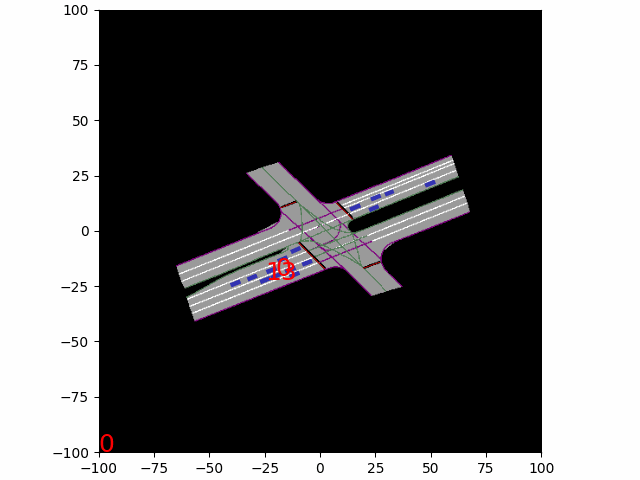

In [38]:
Image(gif_name, width=1000, height=800)